Useful links for practice:
- [Python + Numpy tutorial from CS231n](https://cs231n.github.io/python-numpy)... . We use torch.tensor instead of numpy.array in this video. Their design (e.g. broadcasting, data types, etc.) is so similar that practicing one is basically practicing the other, just be careful with some of the APIs - how various functions are named, what arguments they take, etc. - these details can vary.
- [PyTorch tutorial on Tensor](https://pytorch.org/tutorials/beginne)...
- [Another PyTorch intro to Tensor](https://pytorch.org/tutorials/beginne)...

## Exercises:

### E01: 
Train a trigram language model, i.e. take two characters as an input to predict the 3rd one. Feel free to use either counting or a neural net. Evaluate the loss; Did it improve over a bigram model?

#### Ans
First I'll attempt the solution using counting.

In [1]:
# load the data
words = open('/Users/amralaa/Desktop/nbs/zero2hero/names.txt').read().splitlines()
words[:5]

['emma', 'olivia', 'ava', 'isabella', 'sophia']

We want first to be able to extract trigrams from the data. We'll put them in a dict and keep counts of occurences.

In [2]:
t = {}
pairs = [] #get pairs of characters as we'll need later

for w in words:
    w = ['.'] + list(w) + ['.']
    for ch1, ch2, ch3 in zip(w,w[1:],w[2:]):
        #print(f'{ch1+ch2} {ch3}')
        t[(ch1+ch2, ch3)] = t.get((ch1+ch2, ch3), 0) + 1
        if (ch1+ch2) not in pairs:
            pairs.append(ch1+ch2)   

In [3]:
#t.items()

In [4]:
len(pairs)

601

In [5]:
# we can sort them by frequency same as we did in the lecture
#sorted(t.items(), key=lambda kv:-kv[1])

In [6]:
counts = sorted(t.items(), key=lambda kv:-kv[1])

The `dict.items()` method returns a view object. The view object is a list containing the key-value pairs of the dictionary, as tuples.

We then need to build a table (as torch tensor) which has 1st 2 ccs as rows and 3rd cc as columns such that each cell will give counts of how many times this single cc follows that pair of ccs.

In [7]:
# get unique characters
chars = ['.'] + sorted(list(set(''.join(words))))
chars[:10]

['.', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i']

In [8]:
stoi_c = {}
for ix, ch in enumerate(chars):
    stoi_c[ch] = ix
#stoi_c

In [9]:
stoi_p = {}
for ix, pr in enumerate(pairs):
    stoi_p[pr] = ix
#stoi_p

In [10]:
import torch
import matplotlib.pyplot as plt

In [11]:
# now let's create the table / array / tensor
N = torch.zeros((len(pairs), len(chars)), dtype=torch.int32)
N.shape

torch.Size([601, 27])

In [12]:
# now, let's populate it with counts
for w in words:
    w = ['.'] + list(w) + ['.']
    for ch1, ch2, ch3 in zip(w, w[1:], w[2:]):
        ix1 = stoi_p[ch1+ch2]
        ix2 = stoi_c[ch3]
        N[ix1, ix2] += 1
        #print((ch1+ch2, ch3))

In [13]:
itos_c = {v:k for k,v in stoi_c.items()}
itos_p = {v:k for k,v in stoi_p.items()}

In [14]:
N.shape

torch.Size([601, 27])

Now, we have a table where each row represents a bigram and each column represents how many times a single letter follows that bigram in the dataset.

Remeber we want to make a model that given a bigram can predict the next letter that follows and can generate new names this way. In this model, we could for example start with ".e" and the model predict "m" then we have "em" and the model predicts "a" and so on. 

The question the model is asking each time then: given I see ".e", what is the probability I get "a" or "b" or "c" ..etc.
So, given a bigram, we want a probability distribution over the single characters. We use it to sample from them.
But, we have counts not probabilities. We thus need to generate probabilities from counts.

We have 601 x 27 tensor. We want a probabilty distribution over the single letters (columns) for each of the 601 bigrams (rows). So, we want to divide each cell in a row by the sum of that row.

In [15]:
# to get row sums
N.sum(1, keepdim=True).shape

torch.Size([601, 1])

In [16]:
P = N / N.sum(1, keepdim=True)

In [18]:
#confirm probability worked out
P.sum(1, keepdim=True)[:10]

tensor([[1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000]])

In [19]:
# a generator for the sampling
g = torch.Generator().manual_seed(42)

How to sample? 

We have rows of bigrams ".a, .b, .c, ... aa, ab, .. , zz"\
We have cols of singles "a, b, c .. ."\
The only possible start bigrams are ".a, .b, ...z"\
```
We need to initialize our draw by sampling from the possible 27 ".letter" bigrams out of the 601 bigram rows.
Suppose we pull ".e", we then get its row and sample the next single letter from it eg "m"
Our bigram then becomes "em" and we gets its row and sample a single letter from it.
We keep going until we hit "."
```

The Multinomial distribution is a generalization of the Binomial.\
Binomial counts the successes in a fixed number of trials that can only be categorized as success or failure.\
Multinomial keeps track of trials whose outcomes can fall into multiple categories, such as excellent, adequate, poor; or red, yellow, green, blue. (From:introduction-to-probability-by-joseph-k-blitzstein-and-jessica-hwang).

In [20]:
# frequencies of .letter bigrams (possible start bigrams)
alphabet = sorted(list(set(''.join(words))))
starts = {}
for w in words:
    chs = ['.'] + list(w) + ['.']
    for ch1, ch2 in zip(chs, chs[1:]):
        if ch1 == '.':
            starts[ch1+ch2] = starts.get(ch1+ch2, 0) + 1

In [21]:
#for tup in sorted(starts.items()):
    #print(tup[0], tup[1])

In [22]:
Nstarts = torch.tensor([tup[1] for tup in sorted(starts.items())])

In [23]:
pstarts = Nstarts / Nstarts.sum()

In [24]:
pstarts

tensor([0.1377, 0.0408, 0.0481, 0.0528, 0.0478, 0.0130, 0.0209, 0.0273, 0.0184,
        0.0756, 0.0925, 0.0491, 0.0792, 0.0358, 0.0123, 0.0161, 0.0029, 0.0512,
        0.0642, 0.0408, 0.0024, 0.0117, 0.0096, 0.0042, 0.0167, 0.0290])

In [25]:
# let's create conversion dicts for these 
itos_bi = {i:'.'+ltr for i, ltr in enumerate(alphabet)}
#itos_bi

In [26]:
# now we can sample from starts and find out which bigram we sampled
ixr = torch.multinomial(pstarts, num_samples=1, replacement=True, generator=g).item()
bigram = itos_bi[ixr]
bigram

'.a'

In [27]:
# then we can get the row of that bigram
single = stoi_p[bigram] #next single
single

10

In [28]:
# confirm we have the right bigram
itos_p[10]

'.a'

In [29]:
# get its row
psingle = P[single]
psingle

tensor([0.0000, 0.0469, 0.0431, 0.0070, 0.0830, 0.0125, 0.0048, 0.0039, 0.0206,
        0.0349, 0.0061, 0.0170, 0.1433, 0.0871, 0.1413, 0.0023, 0.0039, 0.0020,
        0.1093, 0.0440, 0.0163, 0.0345, 0.0551, 0.0014, 0.0061, 0.0392, 0.0345])

In [30]:
# sample from it
ixc = torch.multinomial(psingle, num_samples=1, replacement=True, generator=g).item()
ixc

2

In [31]:
mono = itos_c[ixc]
mono

'b'

In [32]:
bigram[1] + mono

'ab'

In [33]:
# next bigram & repeat
stoi_p[bigram[1] + mono]

16

In [34]:
# in a loop
for _ in range(20):
    
    ixbi = torch.multinomial(pstarts, num_samples=1, replacement=True, generator=g).item() # ix of starting bigram
    bi = itos_bi[ixbi] # the bigram itself
    out = [bi[1]] 

    while True:
        ixr = stoi_p[bi] # pull the row of the bigram
        p = P[ixr] # distribution over single letters following the bigram
        ixc = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item() # sample from it
        mono = itos_c[ixc] # get the single letter to add to output
        out.append(mono)
        bi = bi[1]+mono # new bigram (move 1 letter in prev bigram + add new single)
        if mono == '.':
            break
    print(''.join(out))

abelyra.
blisen.
mel.
mak.
aya.
aidalinmakey.
jazoe.
mckeandy.
hel.
nah.
jett.
kylan.
khaiona.
ty.
na.
vi.
kylen.
yadondie.
lie.
aahawayledaloran.


**How to evaluate the quality of this model**

Let's compare the frequency counts (probabilities) of our model to the random model where any single character could follow any bigram.\
If any single character could follow any bigram, what do we expect the probability of that to be? 

?? is it 1/ num bigrams = 1 / 601 ???

In [35]:
for w in words[:5]:
    chs = ['.'] + list(w) + ['.']
    for ch1, ch2, ch3 in zip(w, w[1:], w[2:]):
        ixr = stoi_p[ch1+ch2]
        ixc = stoi_c[ch3]
        print(f'{ch1+ch2} , {ch3} : {P[ixr, ixc]}')

em , m : 0.1300390064716339
mm , a : 0.4285714328289032
ol , i : 0.11147011071443558
li , v : 0.02177419327199459
iv , i : 0.2899628281593323
vi , a : 0.16136114299297333
av , a : 0.19304555654525757
is , a : 0.10790273547172546
sa , b : 0.06328059732913971
ab , e : 0.319778174161911
be , l : 0.3068702220916748
el , l : 0.253078818321228
ll , a : 0.25055763125419617
so , p : 0.03954802080988884
op , h : 0.38947367668151855
ph , i : 0.29901960492134094
hi , a : 0.1111111119389534


### An Exploration of Negative log-likelihood:

Can we summarize all of these probabilities into one number? Each one of these is the probability that our model (the table) produces each one of these (bigram, monogram) tuples. What is the probability that our model produces all these examples (samples)? Well, multiply all these probabilities together. We call the resulting number the likelihood.\
Since multiplying probabilities (floats between 0 and 1) is problematic, we'll change this to a summation of log(probs):

In [36]:
log_likelihood = 0
for w in words[:5]:
    chs = ['.'] + list(w) + ['.']
    for ch1, ch2, ch3 in zip(w, w[1:], w[2:]):
        ixr = stoi_p[ch1+ch2]
        ixc = stoi_c[ch3]
        p = P[ixr, ixc]
        logp = torch.log(p)
        log_likelihood += logp
        print(f'{ch1+ch2} , {ch3} : {p} , {logp}')
print(log_likelihood.item())

em , m : 0.1300390064716339 , -2.0399208068847656
mm , a : 0.4285714328289032 , -0.8472978472709656
ol , i : 0.11147011071443558 , -2.1939988136291504
li , v : 0.02177419327199459 , -3.8270297050476074
iv , i : 0.2899628281593323 , -1.2380025386810303
vi , a : 0.16136114299297333 , -1.8241102695465088
av , a : 0.19304555654525757 , -1.6448290348052979
is , a : 0.10790273547172546 , -2.226525068283081
sa , b : 0.06328059732913971 , -2.760176420211792
ab , e : 0.319778174161911 , -1.1401277780532837
be , l : 0.3068702220916748 , -1.1813303232192993
el , l : 0.253078818321228 , -1.3740543127059937
ll , a : 0.25055763125419617 , -1.3840663433074951
so , p : 0.03954802080988884 , -3.2302396297454834
op , h : 0.38947367668151855 , -0.9429590106010437
ph , i : 0.29901960492134094 , -1.20724618434906
hi , a : 0.1111111119389534 , -2.1972246170043945
-31.259136199951172


In [37]:
#Turn to positive number and take the mean. Do for all words
n = 0 #num probs added
log_likelihood = 0

for w in words:
    chs = ['.'] + list(w) + ['.']
    for ch1, ch2, ch3 in zip(w, w[1:], w[2:]):
        ixr = stoi_p[ch1+ch2]
        ixc = stoi_c[ch3]
        p = P[ixr, ixc]
        logp = torch.log(p)
        n += 1
        log_likelihood += logp
        #print(f'{ch1+ch2} , {ch3} : {p} , {logp}')

nll = - log_likelihood.item()
nll /= n
print(f'Mean negative log-likelihood : {nll}')

Mean negative log-likelihood : 2.2954144641680614


#### Using a Neural Network

How do we train a neural network to do the above? We want the neural network to learn the frequency counts by itself from the data. It takes as input a bigram and outputs a likely monogram following it.\
Each pair of (bigram, monogram) will be an example to the NN.\

In [38]:
len(pairs), len(chars)

(601, 27)

In [39]:
xs = []
ys = []

for w in words:
    chs = ['.'] + list(w) + ['.']
    for ch1, ch2, ch3 in zip(chs, chs[1:], chs[2:]):
        xs.append(stoi_p[ch1+ch2])
        ys.append(stoi_c[ch3])

In [40]:
len(xs) == len(ys)

True

In [41]:
# convert to tensors to provide to NN
xs = torch.tensor(xs)
ys = torch.tensor(ys)

In [42]:
xs.shape, ys.shape

(torch.Size([196113]), torch.Size([196113]))

But these are indices which we can't provide to a neural network. We will need to do one-hot-encoding.

In [43]:
xenc = torch.nn.functional.one_hot(xs).float()

In [44]:
xenc.shape, xenc.dtype

(torch.Size([196113, 601]), torch.float32)

We now get 196113 sample inputs. Each sample is encoded in 601 digits (so will need at least 601 synapses). We try to predict the distribution over the 27 single characters that can follow. 

In [45]:
W = torch.randn((xenc.shape[1], 27), requires_grad=True)

In [46]:
(xenc@W).shape # 1 prediction per example

torch.Size([196113, 27])

In [47]:
ys[:10]

tensor([13, 13,  1,  0, 12,  9, 22,  9,  1,  0])

In [48]:
(xenc@W).exp()

tensor([[ 1.0540,  0.4156,  2.0576,  ...,  4.0413,  0.6635,  1.8298],
        [ 3.1659,  0.9523,  2.8296,  ...,  0.7332,  7.9484,  0.9415],
        [ 0.3793,  1.2079,  0.8295,  ...,  0.7432,  0.7869,  0.6248],
        ...,
        [ 0.1378,  1.4523,  0.7062,  ...,  0.3828,  1.7121,  0.4522],
        [ 1.1233,  1.8824,  1.0794,  ...,  0.4754,  0.9852,  1.1235],
        [ 0.2593,  0.4996,  0.4890,  ..., 11.9291,  1.6390,  1.4182]],
       grad_fn=<ExpBackward0>)

We interpret the numbers the network produces as log(counts) aka logits. We therefore can get counts from them using exp(logits). Once we have counts, we can get probabilities. When we have probabilities, we can get negative log-likelihood.

In [74]:
logits = (xenc@W)
counts = logits.exp()
counts.shape

torch.Size([196113, 27])

In [75]:
probs = counts / counts.sum(dim=1, keepdim=True)
probs.shape

torch.Size([196113, 27])

In [76]:
probs[0]

tensor([0.0322, 0.0127, 0.0628, 0.0397, 0.0611, 0.1151, 0.0525, 0.0359, 0.0022,
        0.0114, 0.0078, 0.0129, 0.0142, 0.0062, 0.0471, 0.0063, 0.0056, 0.0394,
        0.0390, 0.0977, 0.0257, 0.0210, 0.0177, 0.0346, 0.1232, 0.0203, 0.0559],
       grad_fn=<SelectBackward0>)

In [77]:
probs[0].sum()

tensor(1.0000, grad_fn=<SumBackward0>)

In [78]:
# what is the probability of the right next character (ie prob of ys) 
probs[0][ys[0]].item()

0.006221198011189699

In [79]:
len(probs[torch.arange(ys.shape[0]), ys]) # to extract all the probabilties of the true ys

196113

In [80]:
loss = - probs[torch.arange(ys.shape[0]), ys].log().mean()

In [81]:
loss.item()

3.7876932621002197

In [82]:
W.grad = None

In [83]:
loss.backward()

In [84]:
W.data += -2.0 * W.grad

In [103]:
# let's train in a loop
W = torch.randn((xenc.shape[1], 27), requires_grad=True) #initialize random weights
for _ in range(30):
    # forward pass
    logits = xenc@W # output which we interpret as log(counts) aka logits
    counts = logits.exp() # get the coutns themselves
    probs = counts / counts.sum(dim=1, keepdims=True) # get probabilities from counts
    loss = -probs[torch.arange(ys.shape[0]), ys].log().mean() # mean negative log-likelihood
    print(f'loss: {loss.item()}')
    
    # backward pass
    W.grad = None #zero the gradients so they don't accumulate from one loop to the next
    loss.backward() #backprop
    W.data -= 500 * W.grad #update the weights    

loss: 3.7932536602020264
loss: 3.1586859226226807
loss: 2.8944091796875
loss: 2.752422332763672
loss: 2.6721417903900146
loss: 2.5785582065582275
loss: 2.5234906673431396
loss: 2.482287883758545
loss: 2.4555227756500244
loss: 2.4231808185577393
loss: 2.413560390472412
loss: 2.370511293411255
loss: 2.3524491786956787
loss: 2.340670347213745
loss: 2.340574264526367
loss: 2.3122334480285645
loss: 2.3067431449890137
loss: 2.297051429748535
loss: 2.304088830947876
loss: 2.2716405391693115
loss: 2.2624711990356445
loss: 2.256603240966797
loss: 2.254364252090454
loss: 2.2528374195098877
loss: 2.264496326446533
loss: 2.23264217376709
loss: 2.2258687019348145
loss: 2.2217226028442383
loss: 2.2184672355651855
loss: 2.2217140197753906


You see, we ge a slightly better loss than the Frequency Table model.

In [121]:
# sampling
a = torch.tensor([[1,2],[3,4],[5,6]])
a.shape


torch.Size([3, 2])

Can we pre-process the data in a different way? I made an initial choice of how to represent the bigrams that made the sampling later more complicated. Let's redo the processing, but this time, we'll represent each trigram as a 3d vector. So, we'll have a 3D tensor where each cell is encoded by 3 indices x,y,z where P(x,y)->(z) 

In [124]:
chars = ['.'] + sorted(list(set(''.join(words))))
chars[:5]

['.', 'a', 'b', 'c', 'd']

In [127]:
stoi = {s:i for i,s in enumerate(chars)}
itos = {i:s for s,i in stoi.items()}

In [129]:
itos[1], stoi['a']

('a', 1)

In [144]:
D = {}
for w in words[:5]:
    chs = ['.'] + list(w) + ['.']
    for ch1, ch2, ch3 in zip(w, w[1:], w[2:]):
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        ix3 = stoi[ch3]
        D[(ch1+ch2, ch3)] = D.get((ch1+ch2, ch3), 0) + 1
D

{('em', 'm'): 1,
 ('mm', 'a'): 1,
 ('ol', 'i'): 1,
 ('li', 'v'): 1,
 ('iv', 'i'): 1,
 ('vi', 'a'): 1,
 ('av', 'a'): 1,
 ('is', 'a'): 1,
 ('sa', 'b'): 1,
 ('ab', 'e'): 1,
 ('be', 'l'): 1,
 ('el', 'l'): 1,
 ('ll', 'a'): 1,
 ('so', 'p'): 1,
 ('op', 'h'): 1,
 ('ph', 'i'): 1,
 ('hi', 'a'): 1}

In [194]:
N = torch.ones((27,27,27), dtype=torch.int32) # we'll do smoothing (no zero entries)
for w in words:
    chs = ['.'] + list(w) + ['.']
    for ch1, ch2, ch3 in zip(chs, chs[1:], chs[2:]):
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        ix3 = stoi[ch3]
        N[ix1, ix2, ix3] += 1

Let's make the table of counts into one of probabilities. How?\
For each bigram, we need to sum across all possible monograms that could follow it and divide each one by the sum.\
When we only had bigrams (x,y), we sum acorss y. When we have (x,y,z), we sum acorss z.

In [195]:
N.sum(dim=2, keepdim=True).shape

torch.Size([27, 27, 1])

In [196]:
P = N / N.sum(dim=2, keepdims=True)

In [197]:
# confirm 
P[1,1].sum()

tensor(1.0000)

In [199]:
# let's do sampling
for _ in range(10):
    ix1 = 0
    ix2 = 0
    out = []
    
    while True:
        p = P[ix1, ix2]
        ix1 = ix2
        ix2 = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
        out.append(itos[ix2])

        if ix2==0:
            break
        
    print(''.join(out))

daric.
zagori.
len.
tya.
tysen.
cyn.
zarifari.
wina.
thilakikani.
ma.


In [209]:
# evaluation using negative log-likelihood
n = 0
likelihood = 0
for w in words:
    chs = ['.'] + list(w) + ['.']
    for ch1, ch2, ch3 in zip(chs, chs[1:], chs[2:]):
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        ix3 = stoi[ch3]
        
        n += 1
        prob = P[ix1, ix2, ix3]
        logp = prob.log()
        likelihood += logp
        #print(f'{ch1+ch2} -> {ch3} : {prob} : {logp}') 

nll = - likelihood / n
print(f'negative log-likelihood loss: {nll}')

negative log-likelihood loss: 2.092747449874878


#### Let's re-do using NNs

In [223]:
xs = []; ys = []
for w in words:
    chs = ['.'] + list(w) + ['.']
    for ch1, ch2, ch3 in zip(chs, chs[1:], chs[2:]):
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        ix3 = stoi[ch3]
        
        xs.append([ix1, ix2])
        ys.append(ix3)

xs = torch.tensor(xs, dtype=torch.int64)
ys = torch.tensor(ys, dtype=torch.int64)

In [213]:
xs.shape, ys.shape

(torch.Size([196113, 2]), torch.Size([196113]))

In [219]:
xs[:,0]

tensor([ 0,  5, 13,  ..., 26, 25, 26], dtype=torch.int32)

How to do one-hot-encoding for this dataset? 

Consider what one-hot-encoding is doing: it takes a list of numbers (indices) and converts each one to an array of all 0s except one position of that index.\
Here, we have 2 indices x and y. What we can do is create a 3D Weight Matrix (like the table above) and one-hot encode each x and y then use them to index into it.

In [225]:
xs.shape

torch.Size([196113, 2])

In [224]:
# think of 2 inputs x1, x2 and one output y (originally 3 dimensions x, y, z)
x1enc = torch.nn.functional.one_hot(xs[:,0])
x2enc = torch.nn.functional.one_hot(xs[:,1])

In [227]:
# and we can then have a 3D weight matrix to index into
W = torch.randn((27, 27, 27), requires_grad=True)
W.shape

torch.Size([27, 27, 27])

In [226]:
# but indexing might become more complicated then. Instead,
# this could be done in one pass then we change the shape of the tensor
xenc = torch.nn.functional.one_hot(xs).float()
xenc.shape

torch.Size([196113, 2, 27])

In [228]:
xenc[0]

tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.]])

We have 196113 x 2 x 27. If we think of our 3 dimensions (for the 3 letters of the trigram) as x, y, z, then each x,y is represented by a 2 x 27 one-hot vector.\
What if instead of having a 3D weight matrix we combine the first 2 dimensions and make it 2D. We then can similarly combine the 2 dimensions x,y in our one-hot-encoded `xenc` such that each x,y is represented by 1 x 54 one-hot vector 

In [229]:
xenc.view(-1, 54).shape

torch.Size([196113, 54])

In [230]:
W = torch.randn((27*2, 27), requires_grad=True).float()

`W = torch.randn((27*2, 27), requires_grad=True).float()`: 27*2 = 54 is the number of synapses needed. 27 is the number of outputs.

In [234]:
xenc = xenc.view(-1, 54)

In [235]:
# and now proceed as usual
logits = xenc@W
logits.shape

torch.Size([196113, 27])

In [242]:
counts = logits.exp()

In [243]:
probs = counts / counts.sum(dim=1, keepdims=True)

In [244]:
- probs[torch.arange(ys.shape[0]), ys].log().mean()

tensor(4.2774, grad_fn=<NegBackward0>)

In [258]:
import matplotlib.pyplot as plt

In [257]:
xenc = torch.nn.functional.one_hot(xs).float()
xenc = xenc.view(-1, 54)
W = torch.randn((27*2, 27), requires_grad=True).float()
num_epochs = 100
lloss = []

for _ in range(num_epochs):
    #forward pass
    logits = xenc@W
    counts = logits.exp()
    probs = counts / counts.sum(dim=1, keepdims=True)
    loss = - probs[torch.arange(ys.shape[0]), ys].log().mean()
    #print(f'Loss: {loss.item()}')
    lloss.append(loss.item())

    # backward pass
    W.grad = None
    loss.backward()
    W.data -= 50 * W.grad

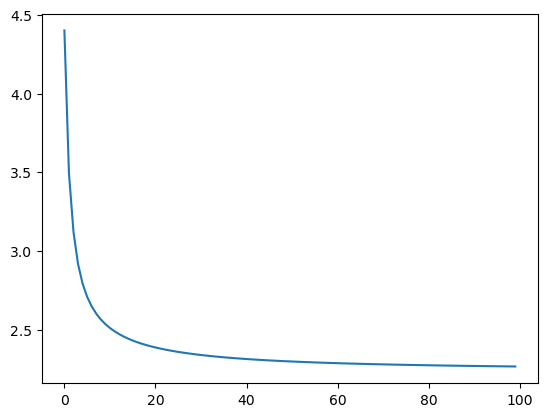

In [259]:
plt.plot(range(num_epochs), lloss);

In [260]:
print(f'Final loss: {lloss[-1]}')

Final loss: 2.2655649185180664


We can there see the loss going down over time and reaching a final loss close to our Table model.

### E02: 
Split up the dataset randomly into 80% train set, 10% dev set, 10% test set. Train the bigram and trigram models only on the training set. Evaluate them on dev and test splits. What can you see?

### E03: 
Use the dev set to tune the strength of smoothing (or regularization) for the trigram model - i.e. try many possibilities and see which one works best based on the dev set loss. What patterns can you see in the train and dev set loss as you tune this strength? Take the best setting of the smoothing and evaluate on the test set once and at the end. How good of a loss do you achieve?

### E04: 
We saw that our 1-hot vectors merely select a row of W, so producing these vectors explicitly feels wasteful. Can you delete our use of F.one_hot in favor of simply indexing into rows of W?

### E05: 
Look up and use F.cross_entropy instead. You should achieve the same result. Can you think of why we'd prefer to use F.cross_entropy instead?

### E06: 
Meta-exercise! Think of a fun/interesting exercise and complete it.